# Clasificador de Edificios Urbanos — Entrenamiento de Modelos

Este notebook implementa y compara tres arquitecturas de transfer learning para clasificar
imágenes de edificaciones urbanas en 8 categorías.

**Experimentos:**
1. ResNet50 (backbone congelado)
2. EfficientNetB3 (backbone congelado)
3. MobileNetV2 (backbone congelado)
4. Fine-tuning del mejor modelo

**Seguimiento:** Todos los experimentos se registran en MLflow.

In [ ]:
# ============================================================
# COLAB SETUP
# ============================================================
import sys, os

IN_COLAB = 'google.colab' in sys.modules
if not IN_COLAB:
    try:
        import google.colab
        IN_COLAB = True
    except ImportError:
        IN_COLAB = False

if IN_COLAB:
    print("Entorno: Google Colab")

    # 1. Instalar dependencias no incluidas en Colab
    import subprocess
    subprocess.run([sys.executable, "-m", "pip", "install",
                    "mlflow", "kagglehub", "-q"], check=True)

    # 2. Credenciales de Kaggle
    try:
        from google.colab import userdata
        os.environ["KAGGLE_USERNAME"] = userdata.get("KAGGLE_USERNAME")
        os.environ["KAGGLE_KEY"]      = userdata.get("KAGGLE_KEY")
        print("Kaggle credentials: cargadas desde Secrets")
    except Exception:
        print("Sube tu kaggle.json cuando aparezca el diálogo:")
        from google.colab import files
        uploaded = files.upload()          # sube kaggle.json
        kaggle_dir = os.path.expanduser("~/.kaggle")
        os.makedirs(kaggle_dir, exist_ok=True)
        os.rename("kaggle.json", f"{kaggle_dir}/kaggle.json")
        os.chmod(f"{kaggle_dir}/kaggle.json", 0o600)
        print("Kaggle credentials: cargadas desde archivo")

    os.environ["STREET_DATA_DIR"] = ""

    print("Setup Colab completo.")
else:
    print("Entorno: Local — omitiendo setup de Colab.")

Entorno: Google Colab
Kaggle credentials: cargadas desde Secrets
Setup Colab completo.


## 1. Configuración

In [58]:
# Instalar dependencias si es necesario
import subprocess, sys

required = [
    "mlflow",
    "seaborn",
    "tqdm",
    "scikit-learn",
    "pandas",
]

for pkg in required:
    try:
        __import__(pkg.replace("-", "_"))
    except ImportError:
        print(f"Instalando {pkg}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg, "-q"])

print("Dependencias verificadas.")

Instalando scikit-learn...
Dependencias verificadas.


In [ ]:
import os

_KAGGLE_CACHE = os.path.expanduser(
    "~/.cache/kagglehub/datasets/mikhailma/"
    "house-rooms-streets-image-dataset/versions/1/"
    "kaggle_room_street_data/street_data"
)
DATA_DIR = os.getenv("STREET_DATA_DIR", _KAGGLE_CACHE)

MLFLOW_TRACKING_URI = os.getenv("MLFLOW_TRACKING_URI", "sqlite:///mlruns.db")
EXPERIMENT_NAME = "building_classifier"

# # Hiperparámetros 1
# IMG_SIZE         = 224
# BATCH_SIZE       = 16
# INITIAL_EPOCHS   = 15
# FINE_TUNE_EPOCHS = 10
# INITIAL_LR       = 1e-3
# FINE_TUNE_LR     = 1e-5
# RANDOM_SEED      = 42

# # Hiperparámetros 2
# IMG_SIZE         = 224
# BATCH_SIZE       = 32
# INITIAL_EPOCHS   = 20
# FINE_TUNE_EPOCHS = 15
# INITIAL_LR       = 1e-4
# FINE_TUNE_LR     = 1e-5
# RANDOM_SEED      = 42

# Hiperparámetros 3
IMG_SIZE         = 224
BATCH_SIZE       = 32
INITIAL_EPOCHS   = 25
FINE_TUNE_EPOCHS = 20
INITIAL_LR       = 1e-4
FINE_TUNE_LR     = 1e-5
RANDOM_SEED      = 42

CLASSES = [
    'apartment', 'church', 'garage', 'house',
    'industrial', 'officebuilding', 'retail', 'roof'
]
CLASS_LABELS = [
    'Apartment', 'Church', 'Garage', 'House',
    'Industrial', 'Office Bldg', 'Retail', 'Roof'
]
NUM_CLASSES = len(CLASSES)

VAL_RATIO  = 0.15
TEST_RATIO = 0.15

print(f"Data dir : {DATA_DIR}")
print(f"Exists   : {os.path.isdir(DATA_DIR)}")
print(f"MLflow   : {MLFLOW_TRACKING_URI}")
print(f"Clases   : {CLASSES}")

Data dir : 
Exists   : False
MLflow   : sqlite:///mlruns.db
Clases   : ['apartment', 'church', 'garage', 'house', 'industrial', 'officebuilding', 'retail', 'roof']


## 2. Imports

In [60]:
import json
import datetime
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

import mlflow
import mlflow.tensorflow

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

print(f"TensorFlow : {tf.__version__}")
print(f"MLflow     : {mlflow.__version__}")
print(f"GPUs       : {tf.config.list_physical_devices('GPU')}")

TensorFlow : 2.19.0
MLflow     : 3.10.0
GPUs       : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 3. Carga de Datos

Descargando dataset desde Kaggle...
Using Colab cache for faster access to the 'house-rooms-streets-image-dataset' dataset.
Dataset listo en: /kaggle/input/house-rooms-streets-image-dataset/kaggle_room_street_data/street_data


Escaneando archivos: 100%|██████████| 19658/19658 [00:00<00:00, 451114.92it/s]

Total imágenes cargadas: 19354

Distribución por clase:
label
apartment         2493
retail            2465
house             2450
industrial        2446
church            2446
garage            2431
roof              2423
officebuilding    2200
Name: count, dtype: int64


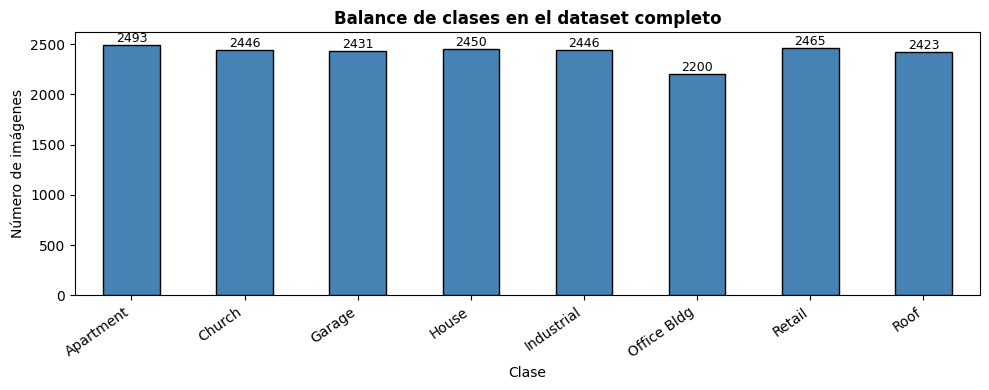

In [ ]:
# Descarga el dataset si DATA_DIR está vacío o no existe
if not os.path.isdir(DATA_DIR):
    import kagglehub, shutil
    print('Descargando dataset desde Kaggle...')
    _path = kagglehub.dataset_download('mikhailma/house-rooms-streets-image-dataset')
    DATA_DIR = os.path.join(_path, 'kaggle_room_street_data', 'street_data')
    print(f'Dataset listo en: {DATA_DIR}')

def build_dataframe(data_dir, categories):
    """Construye un DataFrame mapeando path de imagen → etiqueta.
    Las imágenes están en un directorio plano con la clase en el nombre del archivo.
    """
    paths, labels = [], []
    for fname in tqdm(os.listdir(data_dir), desc="Escaneando archivos"):
        if not fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
        fname_lower = fname.lower()
        for cat in categories:
            if cat in fname_lower:
                paths.append(os.path.join(data_dir, fname))
                labels.append(cat)
                break
    df = pd.DataFrame({'path': paths, 'label': labels})
    df['label_idx'] = df['label'].map({c: i for i, c in enumerate(categories)})
    return df

df = build_dataframe(DATA_DIR, CLASSES)

print(f"Total imágenes cargadas: {len(df)}")
print("\nDistribución por clase:")
print(df['label'].value_counts())

fig, ax = plt.subplots(figsize=(10, 4))
counts = df['label'].value_counts().reindex(CLASSES)
counts.plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')
ax.set_title('Balance de clases en el dataset completo', fontweight='bold')
ax.set_xlabel('Clase')
ax.set_ylabel('Número de imágenes')
ax.set_xticklabels(CLASS_LABELS, rotation=35, ha='right')
for i, v in enumerate(counts):
    ax.text(i, v + 30, str(v), ha='center', fontsize=9)
plt.tight_layout()
plt.show()

In [62]:
# Split estratificado: 70% train | 15% val | 15% test
X_paths = df['path'].values
y_idx   = df['label_idx'].values

X_train_p, X_temp_p, y_train, y_temp = train_test_split(
    X_paths, y_idx,
    test_size=(VAL_RATIO + TEST_RATIO),
    stratify=y_idx,
    random_state=RANDOM_SEED
)
X_val_p, X_test_p, y_val, y_test = train_test_split(
    X_temp_p, y_temp,
    test_size=TEST_RATIO / (VAL_RATIO + TEST_RATIO),
    stratify=y_temp,
    random_state=RANDOM_SEED
)

print(f"Train : {len(X_train_p):>6} imágenes ({len(X_train_p)/len(df)*100:.1f}%)")
print(f"Val   : {len(X_val_p):>6} imágenes ({len(X_val_p)/len(df)*100:.1f}%)")
print(f"Test  : {len(X_test_p):>6} imágenes ({len(X_test_p)/len(df)*100:.1f}%)")

Train :  13547 imágenes (70.0%)
Val   :   2903 imágenes (15.0%)
Test  :   2904 imágenes (15.0%)


## 4. Pipeline de Datos (tf.data)

In [63]:
# Capa de aumentación de datos (solo se aplica en training)
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.15),
    keras.layers.RandomZoom(0.10),
    keras.layers.RandomContrast(0.10),
], name="augmentation")


def load_image(path, label):
    """Lee y decodifica una imagen desde disco."""
    raw = tf.io.read_file(path)
    img = tf.image.decode_image(raw, channels=3, expand_animations=False)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.cast(img, tf.float32)
    return img, label


def make_dataset(paths, labels, training=False, preprocess_fn=None):
    """Construye un tf.data.Dataset eficiente con caché y prefetch.

    Args:
        paths:        array de rutas de archivo
        labels:       array de índices de clase
        training:     si True, aplica shuffle + aumentación
        preprocess_fn: función de preprocesamiento específica del backbone
    Returns:
        tf.data.Dataset listo para .fit()
    """
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

    if training:
        ds = ds.shuffle(buffer_size=4096, seed=RANDOM_SEED)
        ds = ds.map(
            lambda x, y: (data_augmentation(x, training=True), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    if preprocess_fn is not None:
        ds = ds.map(
            lambda x, y: (preprocess_fn(x), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds


print("Pipeline tf.data configurado.")
print(f"  Batch size : {BATCH_SIZE}")
print(f"  Aumentación: flip + rotación + zoom + contraste")

Pipeline tf.data configurado.
  Batch size : 32
  Aumentación: flip + rotación + zoom + contraste


## 5. Fábrica de Modelos

In [ ]:
# Configuración de backbones disponibles
BACKBONE_CONFIG = {
    "ResNet50": {
        "builder":    keras.applications.ResNet50,
        "preprocess": keras.applications.resnet50.preprocess_input,
    },
    # "EfficientNetB0": {
    #     "builder":    keras.applications.EfficientNetB0,
    #     "preprocess": keras.applications.efficientnet.preprocess_input,
    # },
    "EfficientNetB3": {
      "builder":    keras.applications.EfficientNetB3,
      "preprocess": keras.applications.efficientnet.preprocess_input,
    },
    "MobileNetV2": {
        "builder":    keras.applications.MobileNetV2,
        "preprocess": keras.applications.mobilenet_v2.preprocess_input,
    },
}


def build_model(backbone_name):
    """Construye un modelo de clasificación con transfer learning.

    Returns:
        (model, preprocess_fn)
    """
    cfg  = BACKBONE_CONFIG[backbone_name]
    base = cfg["builder"](
        weights="imagenet",
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    base.trainable = False

    inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base(inputs, training=False)

    # x = keras.layers.GlobalAveragePooling2D()(x)
    # x = keras.layers.BatchNormalization()(x)
    # x = keras.layers.Dropout(0.3)(x)
    # x = keras.layers.Dense(256, activation="relu")(x)
    # x = keras.layers.Dropout(0.3)(x)
    # outputs = keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)

    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(512, activation="relu", kernel_regularizer=keras.regularizers.l2(1e-4))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(1e-4))(x)
    x = keras.layers.Dropout(0.3)(x)
    outputs = keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name=f"{backbone_name}_classifier")
    return model, cfg["preprocess"]


def unfreeze_top_layers(model, backbone_name, n_unfreeze=50):
    """Descongela las últimas n_unfreeze capas del backbone para fine-tuning."""
    backbone = model.layers[1]   # la capa base
    backbone.trainable = True
    freeze_until = max(0, len(backbone.layers) - n_unfreeze)
    for layer in backbone.layers[:freeze_until]:
        layer.trainable = False
    trainable = sum(1 for l in backbone.layers if l.trainable)
    print(f"  Backbone: {len(backbone.layers)} capas totales, "
          f"{trainable} descongeladas ({n_unfreeze} top layers)")
    return model


print("Fábrica de modelos lista.")
print(f"  Backbones disponibles: {list(BACKBONE_CONFIG.keys())}")

Fábrica de modelos lista.
  Backbones disponibles: ['ResNet50', 'EfficientNetB3', 'MobileNetV2']


## 6. Configuración MLflow

In [65]:
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)

print(f"Tracking URI : {mlflow.get_tracking_uri()}")
print(f"Experimento  : {EXPERIMENT_NAME}")


def plot_training_curves(history, run_name, save_path):
    """Genera y guarda curvas de accuracy y loss."""
    fig, axes = plt.subplots(1, 2, figsize=(13, 4))
    axes[0].plot(history.history["accuracy"],     label="train", marker='o', ms=3)
    axes[0].plot(history.history["val_accuracy"], label="val",   marker='o', ms=3)
    axes[0].set_title(f"Accuracy — {run_name}")
    axes[0].set_xlabel("Época")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(history.history["loss"],     label="train", marker='o', ms=3)
    axes[1].plot(history.history["val_loss"], label="val",   marker='o', ms=3)
    axes[1].set_title(f"Loss — {run_name}")
    axes[1].set_xlabel("Época")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()


def plot_confusion_matrix(y_true, y_pred, run_name, save_path):
    """Genera y guarda la matriz de confusión."""
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(
        cm, annot=True, fmt="d",
        xticklabels=CLASS_LABELS,
        yticklabels=CLASS_LABELS,
        cmap="Blues", ax=ax
    )
    ax.set_title(f"Matriz de Confusión — {run_name}", fontweight='bold')
    ax.set_ylabel("Real")
    ax.set_xlabel("Predicho")
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()


def run_experiment(run_name, backbone_name, epochs, lr,
                  model=None, n_unfreeze=None):
    """Entrena un modelo y registra todo en MLflow.

    Args:
        run_name     : nombre del experimento en MLflow
        backbone_name: 'ResNet50' | 'EfficientNetB3' | 'MobileNetV2'
        epochs       : número máximo de épocas
        lr           : learning rate inicial
        model        : si se provee, usa este modelo (fine-tuning)
        n_unfreeze   : si se provee, descongela top N capas del backbone
    Returns:
        (model, history, test_accuracy, run_id)
    """
    tmp = "/tmp"
    tag = run_name.replace(" ", "_")

    preprocess_fn = BACKBONE_CONFIG[backbone_name]["preprocess"]
    ds_train = make_dataset(X_train_p, y_train, training=True,  preprocess_fn=preprocess_fn)
    ds_val   = make_dataset(X_val_p,   y_val,   training=False, preprocess_fn=preprocess_fn)
    ds_test  = make_dataset(X_test_p,  y_test,  training=False, preprocess_fn=preprocess_fn)

    with mlflow.start_run(run_name=run_name) as run:

        # ── Parámetros ──────────────────────────────────────────────────────
        mlflow.log_params({
            "backbone":       backbone_name,
            "img_size":       IMG_SIZE,
            "batch_size":     BATCH_SIZE,
            "epochs":         epochs,
            "learning_rate":  lr,
            "fine_tune":      n_unfreeze is not None,
            "n_unfreeze":     n_unfreeze,
            "num_classes":    NUM_CLASSES,
            "train_images":   len(X_train_p),
            "val_images":     len(X_val_p),
            "test_images":    len(X_test_p),
            "augmentation":   "flip+rotation+zoom+contrast",
            "optimizer":      "Adam",
            "loss":           "sparse_categorical_crossentropy",
        })

        # ── Modelo ──────────────────────────────────────────────────────────
        if model is None:
            model, _ = build_model(backbone_name)
        elif n_unfreeze is not None:
            model = unfreeze_top_layers(model, backbone_name, n_unfreeze)

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=lr),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
        )

        callbacks = [
            keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=5,
                restore_best_weights=True,
                verbose=1
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor="val_loss",
                factor=0.5,
                patience=3,
                min_lr=1e-7,
                verbose=1
            ),
        ]

        # ── Entrenamiento ───────────────────────────────────────────────────
        print(f"\n{'='*60}")
        print(f"  {run_name}  |  backbone: {backbone_name}  |  lr={lr}")
        print(f"{'='*60}")
        history = model.fit(
            ds_train,
            validation_data=ds_val,
            epochs=epochs,
            callbacks=callbacks,
            verbose=1
        )

        # ── Log métricas por época ──────────────────────────────────────────
        for epoch_i, (tl, ta, vl, va) in enumerate(zip(
            history.history["loss"],
            history.history["accuracy"],
            history.history["val_loss"],
            history.history["val_accuracy"],
        )):
            mlflow.log_metrics({
                "train_loss":     tl,
                "train_accuracy": ta,
                "val_loss":       vl,
                "val_accuracy":   va,
            }, step=epoch_i)

        # ── Evaluación en test ──────────────────────────────────────────────
        test_loss, test_acc = model.evaluate(ds_test, verbose=0)
        mlflow.log_metrics({"test_loss": test_loss, "test_accuracy": test_acc})

        y_pred = np.argmax(model.predict(ds_test, verbose=0), axis=1)

        # ── Curvas de entrenamiento ─────────────────────────────────────────
        curves_path = f"{tmp}/curves_{tag}.png"
        plot_training_curves(history, run_name, curves_path)
        mlflow.log_artifact(curves_path, "plots")

        # ── Matriz de confusión ─────────────────────────────────────────────
        cm_path = f"{tmp}/cm_{tag}.png"
        plot_confusion_matrix(y_test, y_pred, run_name, cm_path)
        mlflow.log_artifact(cm_path, "plots")

        # ── Reporte de clasificación ────────────────────────────────────────
        report = classification_report(
            y_test, y_pred, target_names=CLASS_LABELS, digits=4
        )
        report_path = f"{tmp}/report_{tag}.txt"
        with open(report_path, "w") as f:
            f.write(f"{run_name}\n{'='*60}\n")
            f.write(report)
        mlflow.log_artifact(report_path, "reports")
        print(report)

        # ── Guardar modelo ──────────────────────────────────────────────────
        mlflow.tensorflow.log_model(model, "model")

        run_id = run.info.run_id
        print(f"\n  Test accuracy : {test_acc*100:.2f}%")
        print(f"  Run ID        : {run_id}")

    return model, history, test_acc, run_id


print("Funciones de experimento listas.")

Tracking URI : sqlite:///mlruns.db
Experimento  : building_classifier
Funciones de experimento listas.


## 7. Experimento 1 — ResNet50 (congelado)


  ResNet50_frozen  |  backbone: ResNet50  |  lr=0.0001
Epoch 1/25
424/424 ━━━━━━━━━━━━━━━━━━━━ 93s 181ms/step - accuracy: 0.2130 - loss: 2.6654 - val_accuracy: 0.4809 - val_loss: 1.6037 - learning_rate: 1.0000e-04
Epoch 2/25
424/424 ━━━━━━━━━━━━━━━━━━━━ 67s 155ms/step - accuracy: 0.3525 - loss: 2.0718 - val_accuracy: 0.5009 - val_loss: 1.5309 - learning_rate: 1.0000e-04
Epoch 3/25
424/424 ━━━━━━━━━━━━━━━━━━━━ 68s 158ms/step - accuracy: 0.3889 - loss: 1.9537 - val_accuracy: 0.5301 - val_loss: 1.4870 - learning_rate: 1.0000e-04
Epoch 4/25
424/424 ━━━━━━━━━━━━━━━━━━━━ 67s 156ms/step - accuracy: 0.4058 - loss: 1.8838 - val_accuracy: 0.5391 - val_loss: 1.4606 - learning_rate: 1.0000e-04
Epoch 5/25
424/424 ━━━━━━━━━━━━━━━━━━━━ 67s 155ms/step - accuracy: 0.4302 - loss: 1.7962 - val_accuracy: 0.5512 - val_loss: 1.4354 - learning_rate: 1.0000e-04
Epoch 6/25
424/424 ━━━━━━━━━━━━━━━━━━━━ 66s 154ms/step - accuracy: 0.4385 - loss: 1.7398 - val_accuracy: 0.5611 - val_loss: 1.4164 - learning_rate: 1

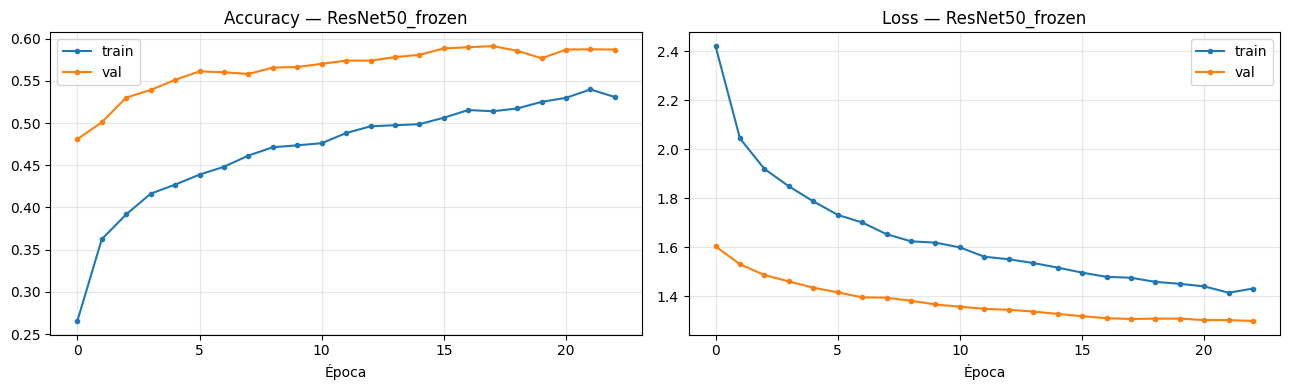

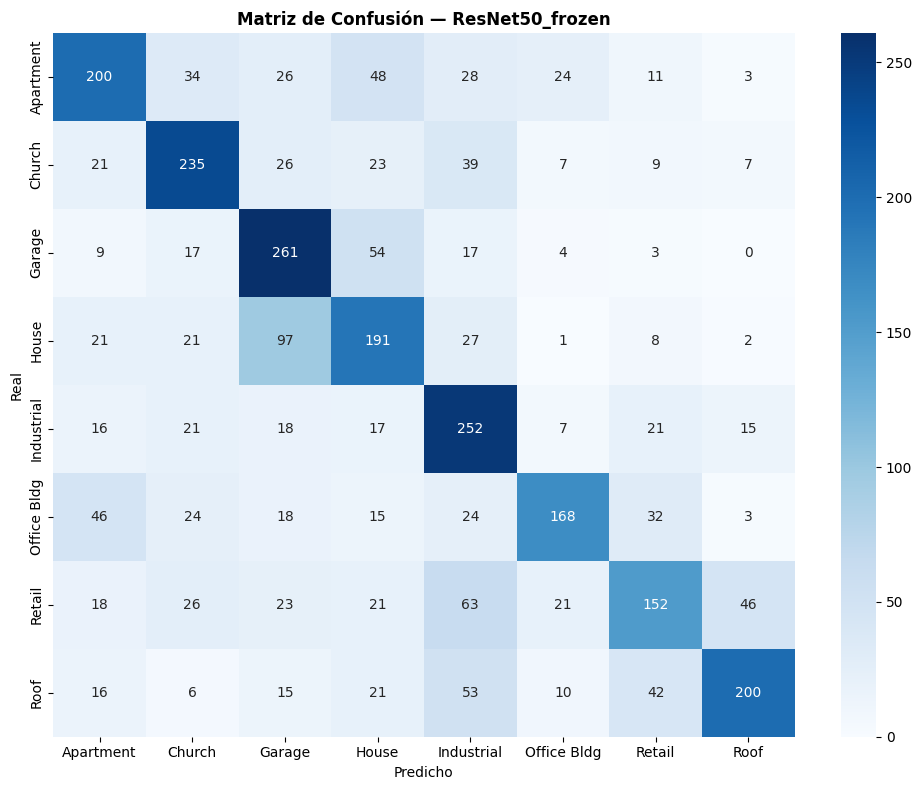

2026/02/21 01:14:17 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/21 01:14:17 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


              precision    recall  f1-score   support

   Apartment     0.5764    0.5348    0.5548       374
      Church     0.6120    0.6403    0.6258       367
      Garage     0.5393    0.7151    0.6148       365
       House     0.4897    0.5190    0.5040       368
  Industrial     0.5010    0.6866    0.5793       367
 Office Bldg     0.6942    0.5091    0.5874       330
      Retail     0.5468    0.4108    0.4691       370
        Roof     0.7246    0.5510    0.6260       363

    accuracy                         0.5713      2904
   macro avg     0.5855    0.5708    0.5702      2904
weighted avg     0.5839    0.5713    0.5697      2904


  Test accuracy : 57.13%
  Run ID        : f3dd470375cc47e285fc1e51c6abf1c5
ResNet50 (frozen) — Test accuracy: 57.13%


In [66]:
model_resnet, hist_resnet, acc_resnet, rid_resnet = run_experiment(
    run_name     = "ResNet50_frozen",
    backbone_name= "ResNet50",
    epochs       = INITIAL_EPOCHS,
    lr           = INITIAL_LR,
)
print(f"ResNet50 (frozen) — Test accuracy: {acc_resnet*100:.2f}%")

## 8. Experimento 2 — EfficientNetB3 (congelado)

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step

  EfficientNetB3_frozen  |  backbone: EfficientNetB3  |  lr=0.0001
Epoch 1/25
424/424 ━━━━━━━━━━━━━━━━━━━━ 142s 234ms/step - accuracy: 0.1894 - loss: 2.7271 - val_accuracy: 0.4829 - val_loss: 1.5594 - learning_rate: 1.0000e-04
Epoch 2/25
424/424 ━━━━━━━━━━━━━━━━━━━━ 53s 122ms/step - accuracy: 0.3450 - loss: 2.1140 - val_accuracy: 0.5208 - val_loss: 1.4874 - learning_rate: 1.0000e-04
Epoch 3/25
424/424 ━━━━━━━━━━━━━━━━━━━━ 52s 121ms/step - accuracy: 0.3697 - loss: 2.0109 - val_accuracy: 0.5336 - val_loss: 1.4531 - learning_rate: 1.0000e-04
Epoch 4/25
424/424 ━━━━━━━━━━━━━━━━━━━━ 52s 120ms/step - accuracy: 0.3855 - loss: 1.9242 - val_accuracy: 0.5470 - val_loss: 1.4216 - learning_rate: 1.0000e-04
Epoch 5/25
424/424 ━━━━━━━━━━━━━━━━━━━━ 52s 121ms/step - accuracy: 0.4006 - loss: 1.8444 - val_accuracy: 0.5484 - val_loss: 1.4077 - learning_rate: 1.0000e-04
Epoch 6/25
424/424 ━━━━━━━━━━━━━━━━━━━━ 52s 121ms/step - accuracy: 0.4110 - loss: 1.8

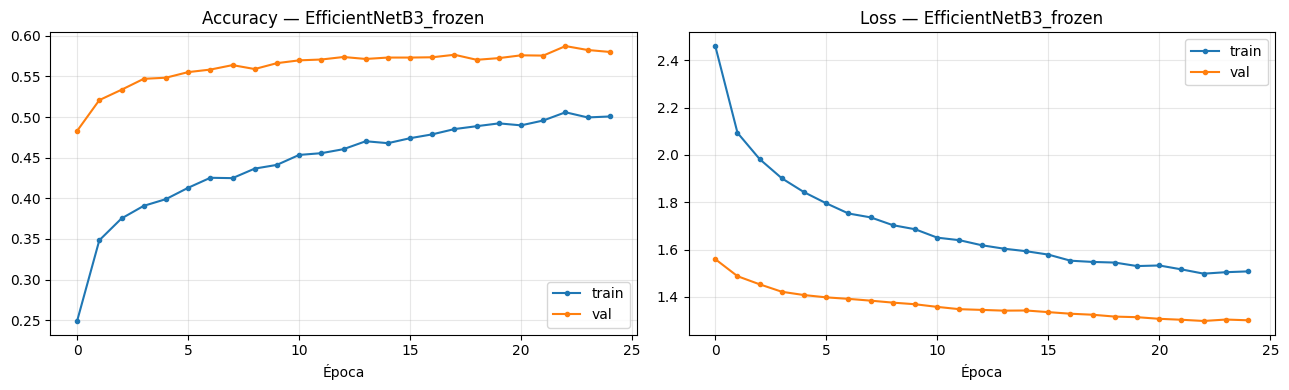

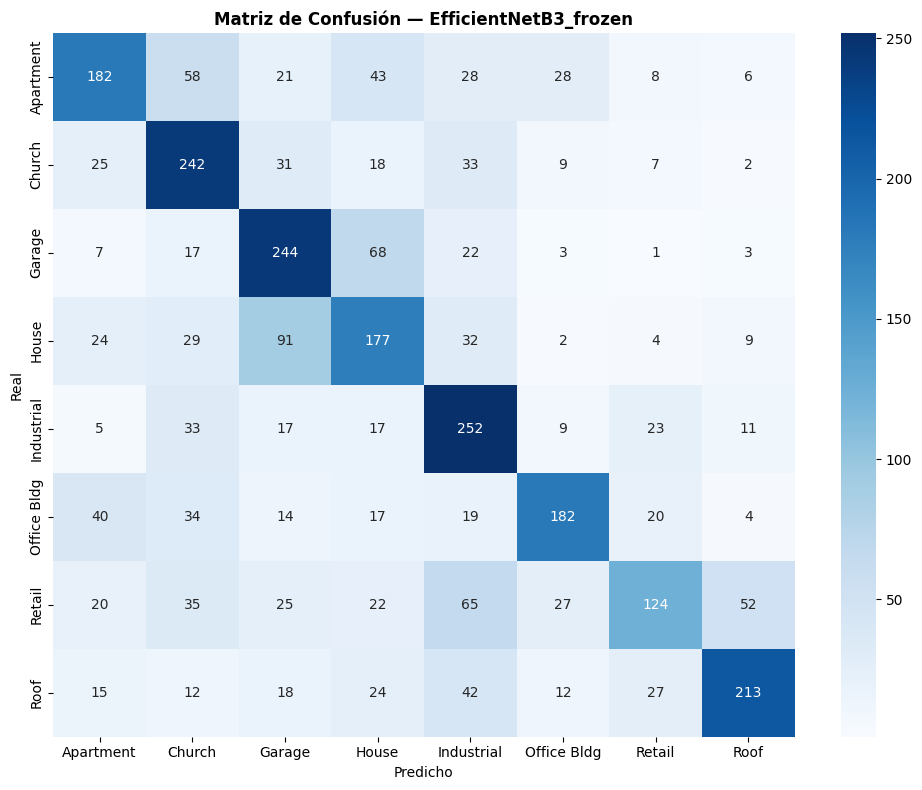

2026/02/21 01:38:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/21 01:38:36 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


              precision    recall  f1-score   support

   Apartment     0.5723    0.4866    0.5260       374
      Church     0.5261    0.6594    0.5852       367
      Garage     0.5293    0.6685    0.5908       365
       House     0.4585    0.4810    0.4695       368
  Industrial     0.5112    0.6866    0.5860       367
 Office Bldg     0.6691    0.5515    0.6047       330
      Retail     0.5794    0.3351    0.4247       370
        Roof     0.7100    0.5868    0.6425       363

    accuracy                         0.5565      2904
   macro avg     0.5695    0.5569    0.5537      2904
weighted avg     0.5680    0.5565    0.5527      2904


  Test accuracy : 55.65%
  Run ID        : caef528cc6e34901bfabeeb38354e093
EfficientNetB3 (frozen) — Test accuracy: 55.65%


In [67]:
model_effnet, hist_effnet, acc_effnet, rid_effnet = run_experiment(
    # run_name     = "EfficientNetB0_frozen",
    # backbone_name= "EfficientNetB0",
    run_name     = "EfficientNetB3_frozen",
    backbone_name= "EfficientNetB3",
    epochs       = INITIAL_EPOCHS,
    lr           = INITIAL_LR,
)
print(f"EfficientNetB3 (frozen) — Test accuracy: {acc_effnet*100:.2f}%")

## 9. Experimento 3 — MobileNetV2 (congelado)


  MobileNetV2_frozen  |  backbone: MobileNetV2  |  lr=0.0001
Epoch 1/25
424/424 ━━━━━━━━━━━━━━━━━━━━ 70s 129ms/step - accuracy: 0.1953 - loss: 2.7600 - val_accuracy: 0.4306 - val_loss: 1.6803 - learning_rate: 1.0000e-04
Epoch 2/25
424/424 ━━━━━━━━━━━━━━━━━━━━ 42s 96ms/step - accuracy: 0.3398 - loss: 2.1007 - val_accuracy: 0.4788 - val_loss: 1.5837 - learning_rate: 1.0000e-04
Epoch 3/25
424/424 ━━━━━━━━━━━━━━━━━━━━ 41s 95ms/step - accuracy: 0.3741 - loss: 1.9773 - val_accuracy: 0.5005 - val_loss: 1.5324 - learning_rate: 1.0000e-04
Epoch 4/25
424/424 ━━━━━━━━━━━━━━━━━━━━ 41s 95ms/step - accuracy: 0.4069 - loss: 1.8834 - val_accuracy: 0.5019 - val_loss: 1.5041 - learning_rate: 1.0000e-04
Epoch 5/25
424/424 ━━━━━━━━━━━━━━━━━━━━ 41s 95ms/step - accuracy: 0.4024 - loss: 1.8466 - val_accuracy: 0.5078 - val_loss: 1.4842 - learning_rate: 1.0000e-04
Epoch 6/25
424/424 ━━━━━━━━━━━━━━━━━━━━ 41s 95ms/step - accuracy: 0.4127 - loss: 1.8039 - val_accuracy: 0.5157 - val_loss: 1.4678 - learning_rate: 

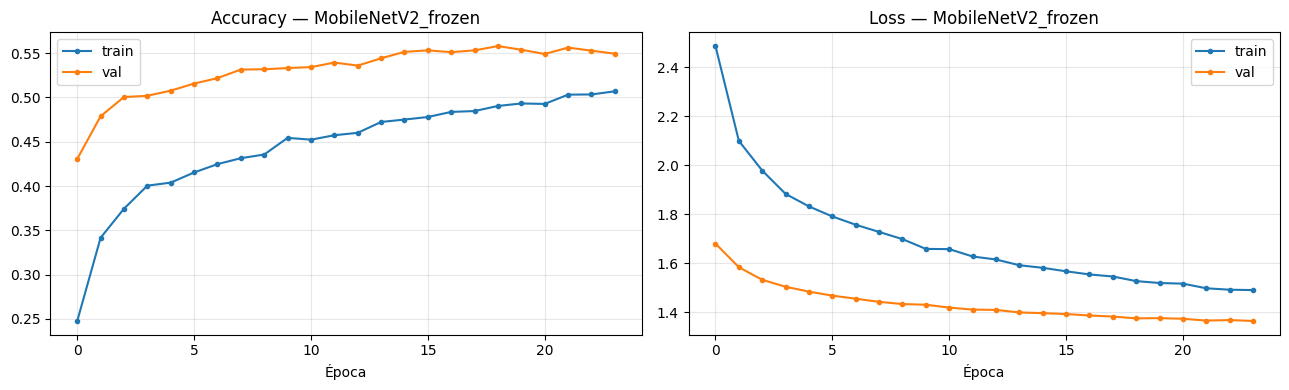

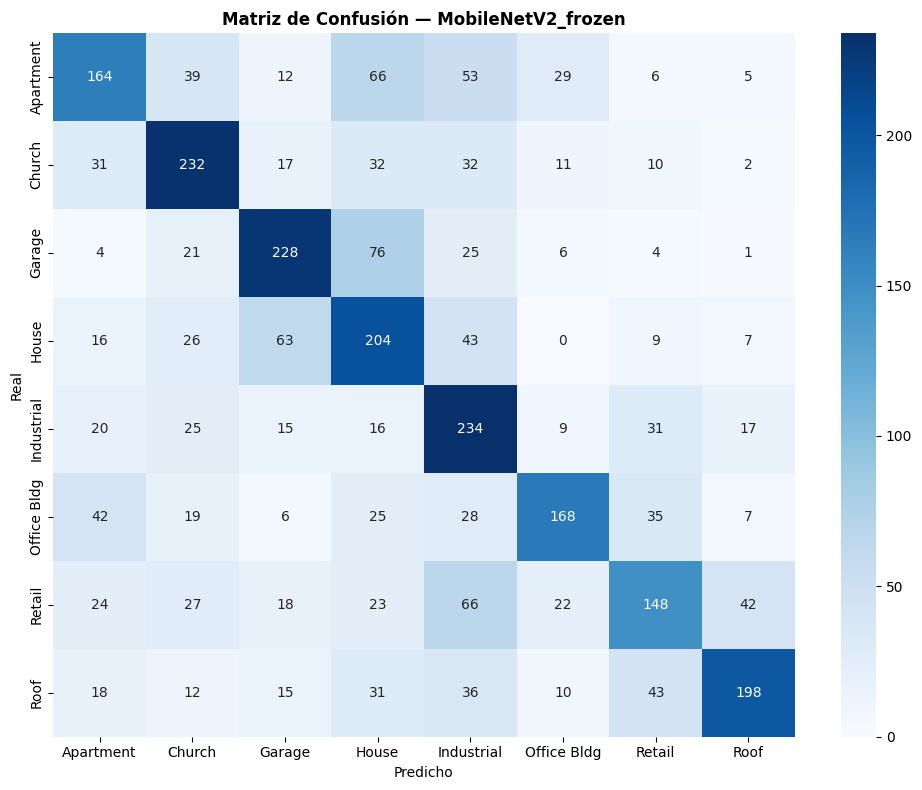

2026/02/21 01:56:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/21 01:56:02 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


              precision    recall  f1-score   support

   Apartment     0.5141    0.4385    0.4733       374
      Church     0.5786    0.6322    0.6042       367
      Garage     0.6096    0.6247    0.6171       365
       House     0.4313    0.5543    0.4851       368
  Industrial     0.4526    0.6376    0.5294       367
 Office Bldg     0.6588    0.5091    0.5744       330
      Retail     0.5175    0.4000    0.4512       370
        Roof     0.7097    0.5455    0.6168       363

    accuracy                         0.5427      2904
   macro avg     0.5590    0.5427    0.5439      2904
weighted avg     0.5573    0.5427    0.5431      2904


  Test accuracy : 54.27%
  Run ID        : 950e377be46e4bf39feba8ba52efa0c5
MobileNetV2 (frozen) — Test accuracy: 54.27%


In [68]:
model_mobilenet, hist_mobilenet, acc_mobilenet, rid_mobilenet = run_experiment(
    run_name     = "MobileNetV2_frozen",
    backbone_name= "MobileNetV2",
    epochs       = INITIAL_EPOCHS,
    lr           = INITIAL_LR,
)
print(f"MobileNetV2 (frozen) — Test accuracy: {acc_mobilenet*100:.2f}%")

## 10. Comparación Baselines → Selección para Fine-tuning

In [69]:
baseline_results = {
    "ResNet50":      (acc_resnet,    model_resnet),
    "EfficientNetB3":(acc_effnet,    model_effnet),
    "MobileNetV2":   (acc_mobilenet, model_mobilenet),
}

print("\n" + "="*55)
print("  COMPARACIÓN BASELINES (backbone congelado)")
print("="*55)
for name, (acc, _) in sorted(baseline_results.items(), key=lambda x: -x[1][0]):
    bar = "█" * int(acc * 40)
    print(f"  {name:<18} {acc*100:5.2f}%  {bar}")
print("="*55)

best_backbone = max(baseline_results, key=lambda k: baseline_results[k][0])
best_acc_base = baseline_results[best_backbone][0]
best_model    = baseline_results[best_backbone][1]

print(f"\n  Mejor baseline : {best_backbone} ({best_acc_base*100:.2f}%)")
print(f"  → Procedemos con fine-tuning de {best_backbone}")


  COMPARACIÓN BASELINES (backbone congelado)
  ResNet50           57.13%  ██████████████████████
  EfficientNetB3     55.65%  ██████████████████████
  MobileNetV2        54.27%  █████████████████████

  Mejor baseline : ResNet50 (57.13%)
  → Procedemos con fine-tuning de ResNet50


## 11. Experimento 4 — Fine-tuning del Mejor Modelo

  Backbone: 175 capas totales, 100 descongeladas (100 top layers)

  ResNet50_finetuned  |  backbone: ResNet50  |  lr=1e-05
Epoch 1/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 173s 313ms/step - accuracy: 0.4814 - loss: 1.5782 - val_accuracy: 0.5918 - val_loss: 1.2921 - learning_rate: 1.0000e-05
Epoch 2/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 113s 263ms/step - accuracy: 0.5339 - loss: 1.4278 - val_accuracy: 0.6094 - val_loss: 1.2563 - learning_rate: 1.0000e-05
Epoch 3/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 113s 263ms/step - accuracy: 0.5593 - loss: 1.3812 - val_accuracy: 0.6156 - val_loss: 1.2278 - learning_rate: 1.0000e-05
Epoch 4/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 113s 264ms/step - accuracy: 0.5731 - loss: 1.3147 - val_accuracy: 0.6252 - val_loss: 1.2013 - learning_rate: 1.0000e-05
Epoch 5/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 113s 264ms/step - accuracy: 0.5953 - loss: 1.2624 - val_accuracy: 0.6376 - val_loss: 1.1784 - learning_rate: 1.0000e-05
Epoch 6/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 113s 264ms/step - accuracy: 0.6026 -

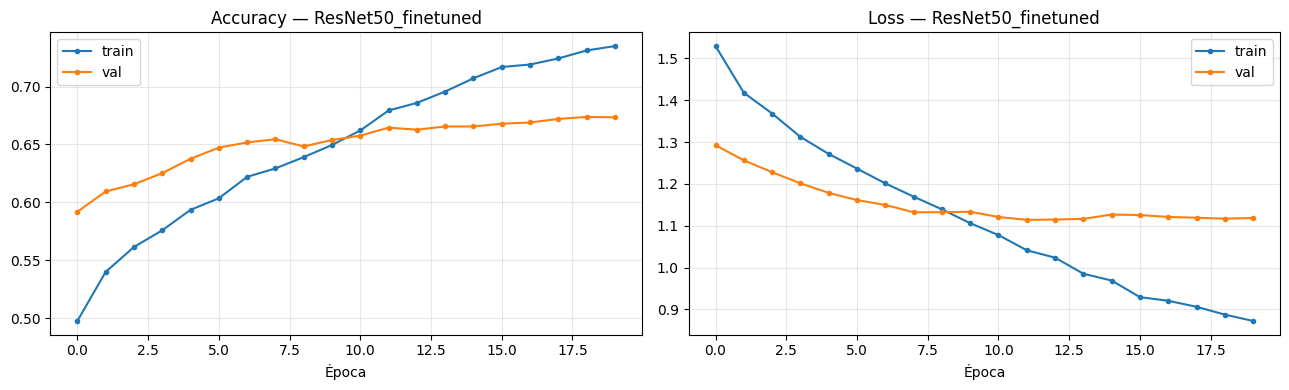

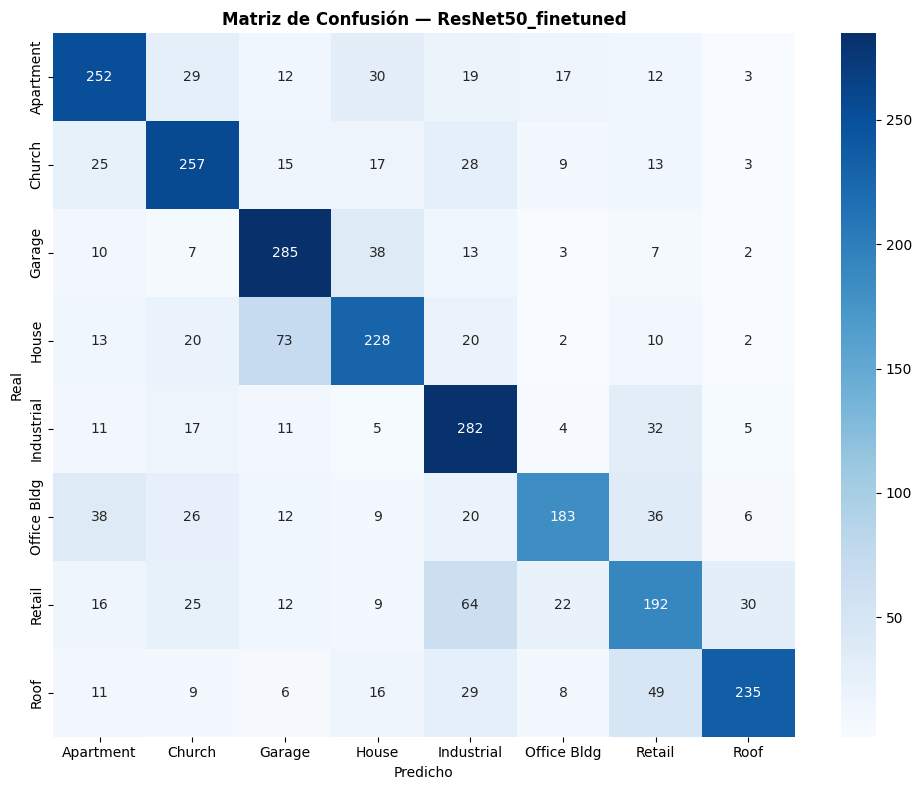

2026/02/21 02:35:16 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/21 02:35:16 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


              precision    recall  f1-score   support

   Apartment     0.6702    0.6738    0.6720       374
      Church     0.6590    0.7003    0.6790       367
      Garage     0.6690    0.7808    0.7206       365
       House     0.6477    0.6196    0.6333       368
  Industrial     0.5937    0.7684    0.6698       367
 Office Bldg     0.7379    0.5545    0.6332       330
      Retail     0.5470    0.5189    0.5326       370
        Roof     0.8217    0.6474    0.7242       363

    accuracy                         0.6591      2904
   macro avg     0.6683    0.6580    0.6581      2904
weighted avg     0.6670    0.6591    0.6582      2904


  Test accuracy : 65.91%
  Run ID        : 6e09fabc0f604edf904b026b09dd82c9
ResNet50 (fine-tuned) — Test accuracy: 65.91%


In [70]:
# Descongelamos las últimas 100 capas del backbone
N_UNFREEZE = 100

model_ft, hist_ft, acc_ft, rid_ft = run_experiment(
    run_name     = f"{best_backbone}_finetuned",
    backbone_name= best_backbone,
    epochs       = FINE_TUNE_EPOCHS,
    lr           = FINE_TUNE_LR,
    model        = best_model,
    n_unfreeze   = N_UNFREEZE,
)
print(f"{best_backbone} (fine-tuned) — Test accuracy: {acc_ft*100:.2f}%")

## 12. Comparación Final de Todos los Experimentos

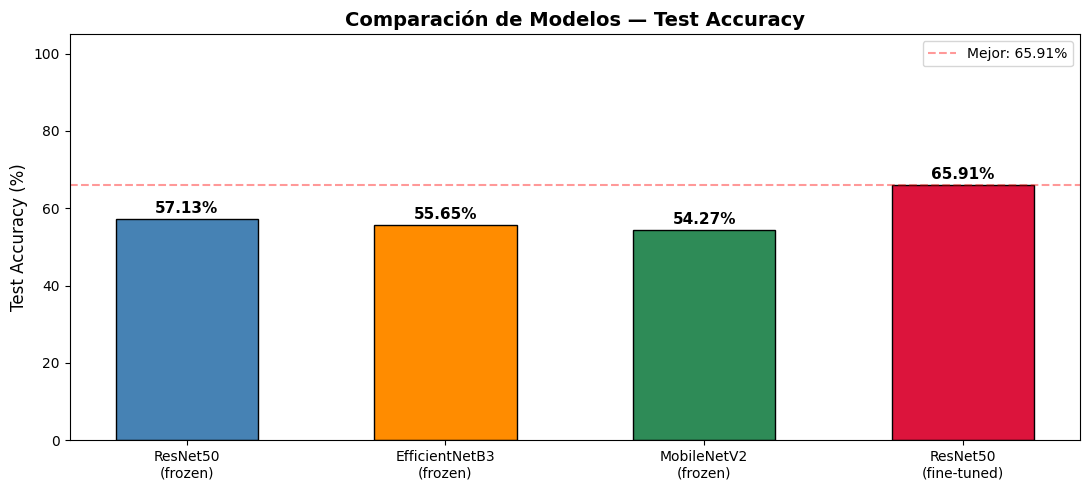


  RESULTADOS FINALES
  ResNet50 (fine-tuned)          65.91%  ← GANADOR
  ResNet50 (frozen)              57.13%
  EfficientNetB3 (frozen)        55.65%
  MobileNetV2 (frozen)           54.27%

Modelo ganador: ResNet50 (fine-tuned)


In [71]:
all_results = {
    "ResNet50\n(frozen)":           acc_resnet,
    "EfficientNetB3\n(frozen)":     acc_effnet,
    "MobileNetV2\n(frozen)":        acc_mobilenet,
    f"{best_backbone}\n(fine-tuned)": acc_ft,
}
all_models = {
    "ResNet50\n(frozen)":           model_resnet,
    "EfficientNetB3\n(frozen)":     model_effnet,
    "MobileNetV2\n(frozen)":        model_mobilenet,
    f"{best_backbone}\n(fine-tuned)": model_ft,
}

names = list(all_results.keys())
accs  = [v * 100 for v in all_results.values()]
colors= ['steelblue', 'darkorange', 'seagreen', 'crimson']

fig, ax = plt.subplots(figsize=(11, 5))
bars = ax.bar(names, accs, color=colors, edgecolor='black', width=0.55)
ax.set_ylim(0, 105)
ax.set_ylabel("Test Accuracy (%)", fontsize=12)
ax.set_title("Comparación de Modelos — Test Accuracy", fontsize=14, fontweight='bold')
ax.axhline(y=max(accs), color='red', linestyle='--', alpha=0.4, label=f'Mejor: {max(accs):.2f}%')
ax.legend()
for bar, acc in zip(bars, accs):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.8,
            f"{acc:.2f}%", ha='center', va='bottom', fontweight='bold', fontsize=11)
plt.tight_layout()
comparison_path = "/tmp/model_comparison.png"
plt.savefig(comparison_path, dpi=150, bbox_inches='tight')
plt.show()

# Log del gráfico de comparación en MLflow
with mlflow.start_run(run_name="summary_comparison"):
    for name, acc in zip(names, accs):
        mlflow.log_metric(name.replace("\n", "_").replace(" ", "_").replace("(", "").replace(")", ""),
                          acc / 100)
    mlflow.log_artifact(comparison_path, "plots")

print("\n" + "="*55)
print("  RESULTADOS FINALES")
print("="*55)
for name, acc in sorted(zip(names, accs), key=lambda x: -x[1]):
    marker = "  ← GANADOR" if acc == max(accs) else ""
    print(f"  {name.replace(chr(10), ' '):<30} {acc:5.2f}%{marker}")
print("="*55)

winner_name = names[np.argmax(accs)]
winner_model = all_models[winner_name]
print(f"\nModelo ganador: {winner_name.replace(chr(10), ' ')}")

## 13. Guardar el Mejor Modelo

In [72]:
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
save_dir  = f"./best_model_{timestamp}"
os.makedirs(save_dir, exist_ok=True)

# Guardar modelo en formato SavedModel (TF nativo)
winner_model.save(f"{save_dir}/model.keras")

# Metadata para servir el modelo
metadata = {
    "classes":        CLASSES,
    "class_labels":   CLASS_LABELS,
    "img_size":       IMG_SIZE,
    "num_classes":    NUM_CLASSES,
    "winner_model":   winner_name.replace("\n", " "),
    "test_accuracy":  round(float(max(accs)) / 100, 4),
    "all_results":    {n.replace("\n", " "): round(a/100, 4) for n, a in zip(names, accs)},
    "timestamp":      timestamp,
    "train_images":   int(len(X_train_p)),
    "val_images":     int(len(X_val_p)),
    "test_images":    int(len(X_test_p)),
}
with open(f"{save_dir}/metadata.json", "w") as f:
    json.dump(metadata, f, indent=2)

print(f"Modelo guardado en : {save_dir}/model")
print(f"Metadata en        : {save_dir}/metadata.json")
print(f"\nResumen:")
for k, v in metadata.items():
    if k != "all_results":
        print(f"  {k:<20}: {v}")

Modelo guardado en : ./best_model_20260221_023533/model
Metadata en        : ./best_model_20260221_023533/metadata.json

Resumen:
  classes             : ['apartment', 'church', 'garage', 'house', 'industrial', 'officebuilding', 'retail', 'roof']
  class_labels        : ['Apartment', 'Church', 'Garage', 'House', 'Industrial', 'Office Bldg', 'Retail', 'Roof']
  img_size            : 224
  num_classes         : 8
  winner_model        : ResNet50 (fine-tuned)
  test_accuracy       : 0.6591
  timestamp           : 20260221_023533
  train_images        : 13547
  val_images          : 2903
  test_images         : 2904
